In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/narou
!ls -a
!pwd

Mounted at /content/drive
/content/drive/MyDrive/narou
 0_eval.txt			     .MANGA.h5
 1_eval.txt			     MANGA.png
 all_metadata.csv		     MANGA_SECONDARY_CHARACTERS.png
 .ANIME.h5			     ncodes_0929
 ANIME.png			     ncodes_0929.txt
 ANIME_SECONDARY_CHARACTERS.png      ncodes_1004
 array_reduce.ipynb		     ncodes_1004.txt
 autoencoder_dim12.pth		     ncodes_HighPoint.txt
 autoencoder.pth		     ncodes_v1.txt
 bin_corpus_low			     ncodes_v2.npy
 bin_corpus_patch		     ncodes_v2.txt
 bin_corpus_v1			     .OFFICIAL_ILLUSTRATIONS.h5
 bottom500.txt			     OFFICIAL_ILLUSTRATIONS.png
'comformer_AEeval.ipynb '	     OFFICIAL_ILLUSTRATIONS_SECONDARY_CHARACTERS.png
 comformer_AEeval_sample.ipynb	     poolformer_for_P.pth
 comformer_AE.ipynb		    'poolformer_only_body.ipynb '
 comformer_dim12.ipynb		     poolformer_only_body_v2.ipynb
 comformer_dim48.ipynb		     poolformer_only_head.ipynb
 corpus10_04			     poolformer.pth
 corpus9_29			     poolformer_v0.5.ipynb
 corpus_patch			     poolformer_v0.

In [2]:
!pip install tqdm
from psutil import virtual_memory
import torch
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime
Thu Nov  9 08:23:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
         

In [3]:
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
import math
import time

dataset

In [4]:
class FileDataset(torch.utils.data.Dataset):
    def __init__(self, corpus, files, max_length):
        self.corpus=corpus
        self.max_length=max_length
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        torch.cuda.empty_cache()
        ncode=self.files[idx]
        seq=torch.load(os.path.join(self.corpus, ncode+".pth"))
        seq=seq[:self.max_length]
        time.sleep(0.5)
        return ncode, seq


In [5]:
from torch.nn.utils.rnn import pad_sequence
def My_collate_func(batch):
    xs = []
    ys = []
    for x, y in batch:
        xs.append(x)
        ys.append(y)



    #データ長を揃える処理
    ys = pad_sequence(ys, batch_first=True)


    return xs, ys

In [6]:
def manual_pad(x):
    batch_size, length, d = x.shape
    if length < 128:

        p=torch.zeros(batch_size, 128-length, d)
        x=torch.concat([x, p], dim = 1)
        print(f"padding to size:{x.shape}")
    else:
        pass
    return x

poolformer

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, dim, dropout = 0.0, max_len = 512*144//4):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        #self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        position = torch.arange(max_len).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim)).to(device)
        pe = torch.zeros(max_len, 1, dim).to(device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        batch_size, max_len, dim = x.shape
        #cls_tokens = self.cls_token.repeat(batch_size, 1, 1)
        #x = torch.concat([cls_tokens, x], dim = 1)
        pe=torch.transpose(self.pe[:max_len], 0,1)
        x = x + pe.repeat(batch_size, 1,1)
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, head_num, dropout = 0.0):
        super().__init__()
        self.dim = dim
        self.head_num = head_num
        self.linear_Q = nn.Linear(dim, dim, bias = False)
        self.linear_K = nn.Linear(dim, dim, bias = False)
        self.linear_V = nn.Linear(dim, dim, bias = False)
        self.linear = nn.Linear(dim, dim, bias = False)
        self.soft = nn.Softmax(dim = 3)
        self.dropout = nn.Dropout(dropout)
    def split_head(self, x):
        x = torch.tensor_split(x, self.head_num, dim = 2)
        x = torch.stack(x, dim = 1)
        return x
    def concat_head(self, x):
        x = torch.tensor_split(x, x.size()[1], dim = 1)
        x = torch.concat(x, dim = 3).squeeze(dim = 1)
        return x

    def forward(self, Q, K, V, mask = None):
        Q = self.linear_Q(Q)   #(BATCH_SIZE,word_count,dim)
        K = self.linear_K(K)
        V = self.linear_V(V)

        Q = self.split_head(Q)   #(BATCH_SIZE,head_num,word_count//head_num,dim)
        K = self.split_head(K)
        V = self.split_head(V)

        QK = torch.matmul(Q, torch.transpose(K, 3, 2))
        QK = QK/((self.dim//self.head_num)**0.5)

        if mask is not None:
        #print(f"QK:{np.shape(QK)}, mask:{np.shape(mask)}")
            QK = QK + mask

        softmax_QK = self.soft(QK)
        softmax_QK = self.dropout(softmax_QK)

        QKV = torch.matmul(softmax_QK, V)
        QKV = self.concat_head(QKV)
        QKV = self.linear(QKV)
        return QKV

class FeedForward(nn.Module):

    def __init__(self, dim, dropout = 0.0):
        super().__init__()
        hidden_dim=int(dim*2)
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(dim, hidden_dim)
        self.gelu = nn.GELU()
        self.linear_2 = nn.Linear(hidden_dim, dim)
    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

class transblock(nn.Module):

    def __init__(self, dim, head_num, dropout = 0.0):
        super().__init__()
        self.MHA = MultiHeadAttention(dim, head_num)
        self.layer_norm_1 = nn.LayerNorm([dim])
        self.layer_norm_2 = nn.LayerNorm([dim])
        self.FF = FeedForward(dim)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        Q = K = V = x
        x = self.layer_norm_1(x)
        x = self.MHA(Q, K, V)
        x = self.dropout_1(x)
        x = x + Q
        _x = x.clone()
        x = self.layer_norm_2(x)
        x = self.FF(x)
        x = self.dropout_2(x)
        x = x + _x
        return x


class transformer(nn.Module):
    def __init__(self, channel, kernal_size=2, layer=4, dropout = 0.0, reverse=False):
        super().__init__()
        if reverse == False:
            out_channel=channel//2
        else:
            out_channel=channel*2
        self.conv=ConvProj(channel, out_channel, kernal_size, stride=kernal_size, reverse=reverse)
        self.pe=PositionalEncoding(out_channel)
        self.transformer = nn.Sequential(*[transblock(out_channel, out_channel//4) for _ in range(layer)])

    def forward(self, x):
        x=self.conv(x)
        x = torch.transpose(x, 1, 2)
        x=self.pe(x)
        x=self.transformer(x)
        x = torch.transpose(x, 1, 2)
        return x

class ConvProj(nn.Module):
    def __init__(self, in_channel, out_channel, kernal_size=2, stride=2, reverse=False):
        super().__init__()


        self.point=nn.Conv1d(in_channel, out_channel, 1, 1, padding=0)

        if reverse==False:
            self.conv2=nn.Conv1d(out_channel, out_channel, kernal_size, stride, groups=out_channel, padding=0)
            self.pool=nn.AvgPool1d(kernal_size, stride=kernal_size, padding=0)
        else:
            self.conv2=nn.ConvTranspose1d(out_channel, out_channel, kernal_size, stride, groups=out_channel, padding=0)
            self.pool=nn.ConvTranspose1d(out_channel, out_channel, kernal_size, stride, groups=out_channel, padding=0)
        self.conv1=nn.Conv1d(in_channel,out_channel, 1, 1, padding=0)
        self.conv3=nn.Conv1d(out_channel, out_channel, 1, 1,  padding=0)
        self.gelu=nn.GELU()
        self.norm1=nn.GroupNorm(1, out_channel)
        self.norm2=nn.GroupNorm(1, out_channel)
    def shortcut(self, x):
        x=self.point(x)
        x=self.pool(x)
        return x



    def forward(self, x):
        _x=self.shortcut(x)
        x=self.conv1(x)
        x=self.norm1(x)
        x=self.gelu(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.norm2(x)
        x=self.gelu(x)
        x+=_x

        return x

class ConvBlock(nn.Module):
    def __init__(self, channel, kernal_size=3, stride=1):
        super().__init__()

        self.shortcut=nn.Sequential(nn.Identity())

        self.conv2=nn.Conv1d(channel//2, channel//2, kernal_size, stride, groups=channel//2, padding=kernal_size//2)
        self.conv1=nn.Conv1d(channel,channel//2, 1, 1, padding=0)
        self.conv3=nn.Conv1d(channel//2, channel, 1, 1,  padding=0)
        self.gelu=nn.GELU()
        self.norm1=nn.GroupNorm(1, channel//2)
        self.norm2=nn.GroupNorm(1, channel)


    def forward(self, x):
        _x=self.shortcut(x)
        x=self.conv1(x)
        x=self.norm1(x)
        x=self.gelu(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.norm2(x)
        x=self.gelu(x)
        x+=_x
        return x

class stage(nn.Module):
    def __init__(self, channel, kernal_size=2, stride=2, min_ch=48, reverse=False):
        super().__init__()
        if reverse == False:
            out_channel=channel//2
        else:
            out_channel=channel*2

        self.conv1=ConvProj(channel, out_channel, kernal_size, stride=stride, reverse=reverse)
        self.conv2=nn.Sequential(*[ConvBlock(out_channel,kernal_size=3) for _ in range(3)])

        if out_channel <= min_ch:
            self.next_stage=nn.Identity()
        else:
            if  out_channel >= 768 :
                self.next_stage=nn.Identity()
            else:
                self.next_stage=stage(out_channel, kernal_size=2, stride=2, reverse=reverse)

    def forward(self, x):
        #print(x.shape)
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.next_stage(x)

        return x



class autoencoder(nn.Module):
    def __init__(self, min_ch=48):
        super().__init__()
        self.down_stage=stage(768, min_ch=min_ch)
        self.up_stage=stage(48, min_ch=min_ch, reverse=True)
        self.trans1=transformer(48)
        self.trans2=transformer(24)
        self.trans3=transformer(12, reverse=True)
        self.trans4=transformer(24, reverse=True)
        self.linear=nn.Linear(768, 768)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x0=x.shape
        x=self.down_stage(x)
        x=self.trans1(x)
        x=self.trans2(x)
        #print(x.shape)
        x=self.trans3(x)
        x=self.trans4(x)
        x=self.up_stage(x)
        #print(x0, x.shape)
        x = torch.transpose(x, 1, 2)
        x=self.linear(x)

        return x

train

  0%|          | 0/2 [00:00<?, ?it/s]

['N3777BW'] 0.045064423233270645


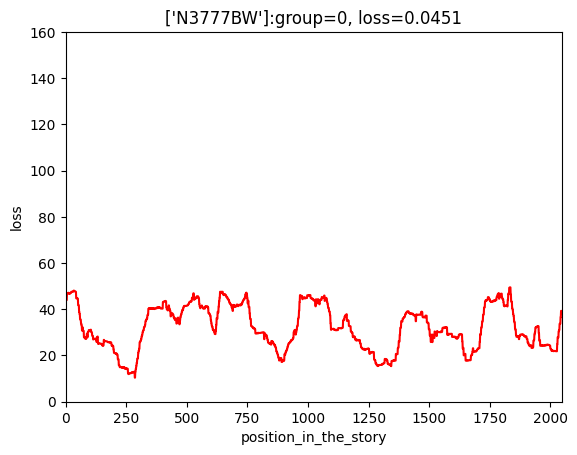

 50%|█████     | 1/2 [00:01<00:01,  1.47s/it]

['N3373FC'] 0.12688729166984558


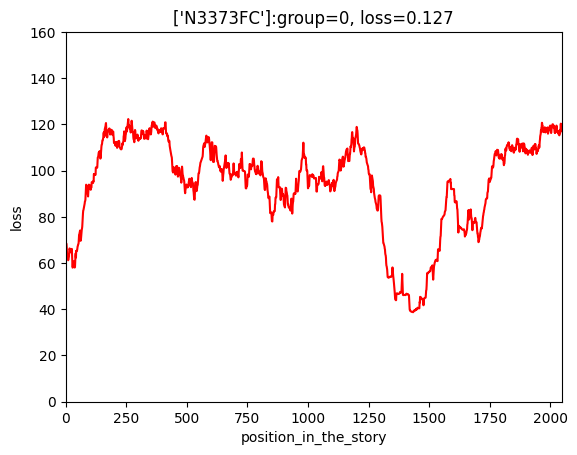

  0%|          | 0/2 [00:00<?, ?it/s]

['N7594CT'] 0.04126940667629242


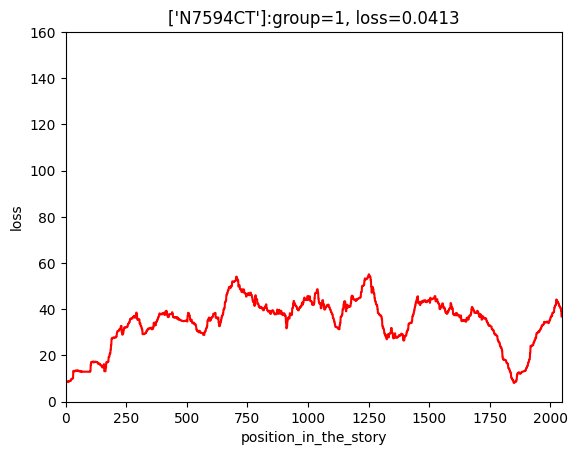

 50%|█████     | 1/2 [00:01<00:01,  1.67s/it]

['N0980BS'] 0.13229012489318848


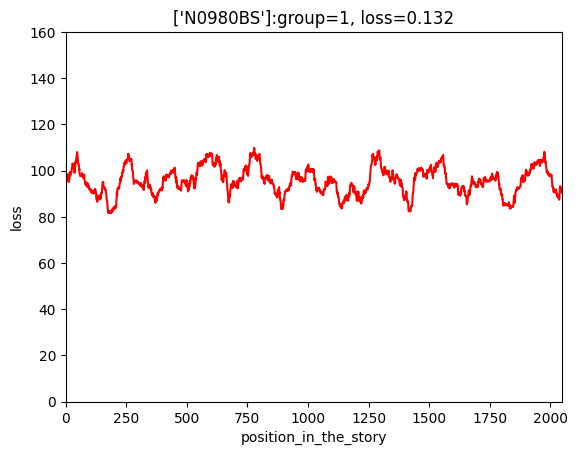

100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


In [11]:

def main(device):
    max_length = 128*256
    batch_size = 1
    epochs = 32
    lr =  3e-5
    valid_rate = 0.05
    min_ch=12
    num=128
    b=np.ones(num)/num
    model = torch.load("autoencoder_dim12.pth").to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    high_corpus = "bin_corpus_patch"
    low_corpus = "bin_corpus_low"
    hd=["N7594CT", "N0980BS"]
    ld=["N3777BW", "N3373FC"]
    low_dataset = FileDataset(low_corpus, ld, max_length)
    high_dataset = FileDataset(high_corpus, hd, max_length)
    low_dataloader = torch.utils.data.DataLoader(low_dataset,  batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=My_collate_func, num_workers=0)
    high_dataloader = torch.utils.data.DataLoader(high_dataset,  batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=My_collate_func, num_workers=0)
    data=[]
    n=0
    for dataloader in [low_dataloader, high_dataloader]:


        #valid
        model.eval()
        total_loss_valid=[]
        with torch.no_grad():
            for ncode, seq in tqdm(dataloader):
                if seq.shape[1] < 128:
                    #seq=manual_pad(seq)
                    continue
                seq=seq.to(device)
                output=model(seq)
                N, Li, D = seq.shape
                N, Lo, D = output.shape
                if Lo > Li:
                    output=output[:,:Li,:]
                else:
                    seq=seq[:,:Lo,:]
                loss_valid=criterion(output, seq)

                loss=torch.squeeze(output-seq)
                loss=loss.to('cpu').detach().numpy().copy()
                loss=np.sum(loss**2, axis=1)
                loss=np.convolve(loss, b, mode='valid')
                print(ncode, loss_valid.item())
                plt.title(f"{ncode}:group={n}, loss={loss_valid.item():1.3}")
                plt.xlabel('position_in_the_story')
                plt.ylabel('loss')
                plt.xlim(0, 128*16)
                plt.ylim(0, 160)
                plt.plot(loss[:128*256], color='r')
                plt.show()
                torch.cuda.empty_cache()
        n+=1



    return model

if __name__ == "__main__":
    main(device)